# Image Classification with Neural Networks
## AI CA#5
## FALL 2020
### Amin Asadi

In this project we want to implement a neural network to classify FASHION-MNIST dataset. FASHION-MNIST consists of 10 categories of clothing like shoes, pants and T-shirts.

### Import Libraries

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time

### Import Data

In [4]:
X_train = pd.read_csv('./Fashion-MNIST/trainData.csv', header=None)
X_test = pd.read_csv('./Fashion-MNIST/testData.csv', header=None)
y_train = pd.read_csv('./Fashion-MNIST/trainLabels.csv', header=None)
y_test = pd.read_csv('./Fashion-MNIST/testLabels.csv', header=None)

print('number of train samples =', X_train.shape[0])
print('number of test samples =', X_test.shape[0])
print('number of features =', X_train.shape[1])

number of train samples = 60000
number of test samples = 10000
number of features = 784


# Step One: Data Visualization and Preprocessing

## 1.1: Depicting samples from each class of data:

Here we want to see SAMPLE_NUM samples from each category. We know that each sample is a (28, 28) image which is flattened to 28*28=784 features. So we reshape each sample to (28,28) and use pyplot imshow method to depict the sample. We have two loops, one iterates over classes and the other iterates SAMPLE_NUM times on the samples of each class.

**Also note that the images have only one color channel so they are not RGB.**

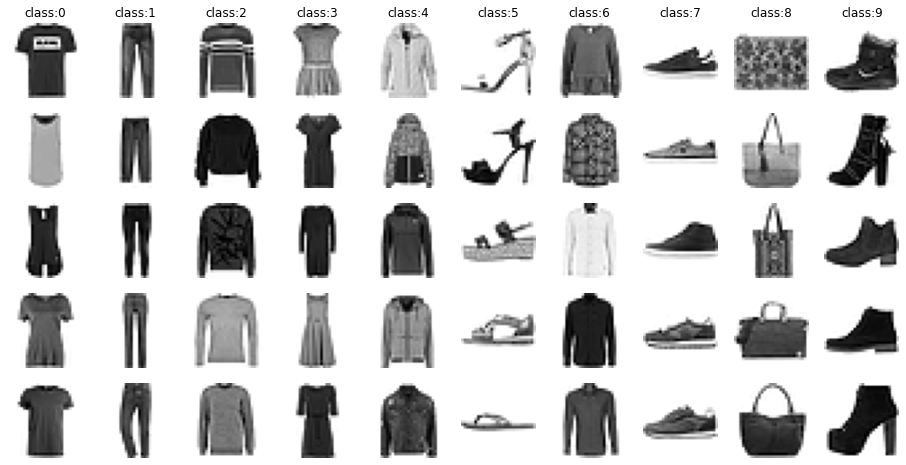

In [5]:
IMAGE_SHAPE = (28, 28)
SAMPLE_NUM = 5
CLASS_NUM = 10

def show_samples(X_train, y_train):
    fig, axes = plt.subplots(SAMPLE_NUM, CLASS_NUM, figsize=(16,8))
    
    for i in range(CLASS_NUM):
        y_i = (y_train==i)[0]
        x_i = X_train[y_i].iloc[:SAMPLE_NUM].to_numpy()
        for j in range(SAMPLE_NUM):
            image = x_i[j].reshape(IMAGE_SHAPE)
            axes[j][i].imshow(image, cmap=plt.cm.gray_r)
            axes[j][i].set_axis_off()
    
    for i in range(CLASS_NUM):
        axes[0][i].set_title('class:{}'.format(i))

show_samples(X_train, y_train)

## 1.2: Bar plot of the class sample counts

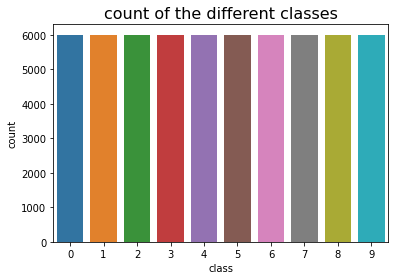

In [6]:
X_train['class'] = y_train
sns.countplot(x='class', data=X_train);
plt.title('count of the different classes', fontsize=16);
X_train = X_train.drop(columns='class')

#### Result: We see that all the classes has 600 samples. So the dataset is balanced.

## 1.3: Scaling Samples:

In [7]:
SCALE = 255

def transform(X_train, X_test):
    X_train /=  SCALE
    X_test /= SCALE
    return X_train, X_test

X_train, X_test = scaler(X_train, X_test)

# Step Two: Building a Neural Network:

# Dataloader

In [6]:
np.random.seed(10)

In [8]:
class Dataloader:
    
    def __init__(self, data, labels, n_classes, batch_size=None, shuffle=False):
        
        assert len(data)==len(labels)
        self.__n_classes = n_classes
        self.__batch_size = batch_size
        self.__shuffle = shuffle
        self.__data = data
        self.__onehot_labels = self.__onehot(labels, self.__n_classes)

    def __onehot(self, labels, n_classes):
        # TODO: Implement
        onehot_vectors = []
        for l in labels:
            binary = np.zeros((self.__n_classes, 1), dtype='int')
            binary[l] = 1
            onehot_vectors.append(binary)
        return np.array(onehot_vectors)

    def __shuffle_dataset(self):
        # TODO: Implement
        index_list = np.arange(self.__data.shape[0])
        np.random.shuffle(index_list)

        self.__data = self.__data[index_list]
        self.__onehot_labels = self.__onehot_labels[index_list]

    def __iter__(self):
        
        if self.__shuffle:
            self.__shuffle_dataset()
            
        if self.__batch_size==None:
            yield (np.matrix(self.__data), np.matrix(self.__onehot_labels))
            return
            
        for idx in range(0, len(self.__data), self.__batch_size):
            yield (np.matrix(self.__data[idx:idx+self.__batch_size]), 
                   np.matrix(self.__onehot_labels[idx:idx+self.__batch_size]))

In [9]:
X_train = X_train.to_numpy()
X_test = X_test.to_numpy()
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

# Activation Functions

In [10]:
class Identical:
    
    def __init__(self): pass
    
    def __val(self, matrix):
        identical_value = np.matrix(matrix, dtype=float)
        return identical_value

    def derivative(self, matrix):
        temp = np.matrix(matrix, dtype=float)
        identical_derivative = np.matrix(np.full(np.shape(temp), 1.))
        return identical_derivative
    
    def __call__(self, matrix):
        return self.__val(matrix)
    

class Relu:
    
    def __init__(self): pass
    
    def __relu(self, matrix):
        relu_value = np.where(matrix > 0, matrix, 0) 
        return relu_value

    def derivative(self, matrix):
        # TODO: Implement
        relu_derivative = np.where(matrix > 0, 1, 0) 
        return relu_derivative
    
    def __call__(self, matrix):
        return self.__relu(matrix)

    
class LeakyRelu:
    
    def __init__(self, negative_slope=0.01):
        self.negative_slope = 0.01
    
    def __val(self, matrix):
        # TODO: Implement
        leacky_relu_value = np.where(matrix > 0, matrix, matrix * self.negative_slope)
        return leacky_relu_value

    def derivative(self, matrix):
        # TODO: Implement
        leacky_relu_derivative = np.where(matrix > 0, 1, 0.01) 
        return leacky_relu_derivative
    
    def __call__(self, matrix):
        return self.__val(matrix)


class Tanh:

    def __init__(self): pass

    def __val(self, matrix):
        # TODO: Implement
        tanh_value = 1 / (1 + np.tanh(matrix))
        return tanh_value

    def derivative(self, matrix):
        # TODO: Implement
        tanh_value = self.__val(matrix)
        sigmoid_derivative =  1 - np.power(tanh_value, 2)
        return sigmoid_derivative
    
    def __call__(self, matrix):
        return self.__val(matrix)

    
class Sigmoid:
    
    def __init__(self): pass

    def __val(self, matrix):
        # TODO: Implement
        sigmoid_value = 1 / (1 + np.exp(-matrix))
        return sigmoid_value

    def derivative(self, matrix):
        # TODO: Implement
        sigmoid_value = self.__val(matrix)
        sigmoid_derivative = np.multiply(sigmoid_value, (1 - sigmoid_value))
        return sigmoid_derivative
    
    def __call__(self, matrix):
        return self.__val(matrix)


class Softmax:
    
    def __init__(self): pass

    def __val(self, matrix):
        # TODO: Implement
        exp_matrix = np.exp(matrix - np.max(matrix, axis=1).reshape(-1,1))
        softmax_value = exp_matrix / np.sum(exp_matrix, axis=1).reshape(-1,1)
        return softmax_value
    
    def __call__(self, matrix):
        return self.__val(matrix)

# Loss Function

In [11]:
class CrossEntropy: #(with softmax)
    
    def __init__(self): pass

    def __val(self, expected_val, true_val):
        assert np.shape(true_val)==np.shape(expected_val)
        # TODO: Implement
        sm = Softmax()
        y_pred = sm(true_val)
        cross_entropy_value = -np.sum(np.multiply(expected_val, np.log(y_pred))) / len(expected_val)
        return cross_entropy_value
        
    def derivative(self, expected_val, true_val):
        assert np.shape(true_val)==np.shape(expected_val)
        # TODO: Implement
        sm = Softmax()
        y_pred = sm(true_val)
        cross_entropy_derivative = y_pred - expected_val 
        return cross_entropy_derivative
    
    def __call__(self, expected_val, true_val):
        return self.__val(expected_val, true_val)

### Back Propagation:
Back-propagation is the process of updating the weights of the network. In this process we use gradient descent for updating weithts.
##### Why do we use gradient descent? Why not just find the best wieght directly?
Because the direct solution(also called "Normal Equation") requires multiplication of very large matrices which is neither memory nor time efficient.
##### Gradient Descent:
Gradient Descent is a numerical method for finding local minima of a function. For smooth function it is garantied to find the global minima but for others it may find a suboptimal point. In gd, we find the gradient of the (loss)function w.r.t the parameters which we want to update. Then change the parameters proportional to |gradient| and towards the sign of the gradient because we know that the gradient indicates the slope and slope leads to the extermum point.

For finding the gradients we use chain rule:
- First off we find the derivative of the loss function to the output of the last layer. For this purpuse to be easy we use the combination of **Softmax Activation** and **Cross Entropy Loss**. In this way the derivative is easily computed by softmax(last layer output) - y_expected. We call this derivative dA.

- The we pass the dA to the last layer. For each single training sample, this layer finds the derivated of A w.r.t it'sparameters: dA/dW, dA/db by the formula(L is loss function):

\\[\frac{dL}{dW} = \frac{dL}{dA} * \frac{dL}{dA} * \frac{dZ}{dW}\\]
\\[\frac{dL}{db} = \frac{dL}{dA} * \frac{dL}{dA} * \frac{dZ}{db}\\]

(As we mentioned, for the last layer the result of the first two terms is dL/dZ = A - y_true.)

Then the updating rule is(lr is learning rate, we will discuss it later):

\\[ W := W - lr*\frac{dL}{dW} \\]
\\[ b := b - lr*\frac{dL}{db} \\]

Because we will use batch gradient descent we can use matrix algebra and will perform all the updates in a single assignment depicted in the picture below:

<img src="backprop.png" width="600" height="600" />

Also we must find derivative of loss function w.r.t X, i.e., the output of the previous layer as the backprop tensor. Similar to dL/dW, dL/dX can be calculated as:


backprop tensor = 
\\[\frac{dL}{dX} = \frac{dL}{dZ} * dX^T\\]

We pass it back to the previous layer as the backprop tensor and repeat the above step for all the previous layers.

# Layer

In [21]:
class Layer:

    DEFAULT_LOW, DEFAULT_HIGH, DEFAULT_MEAN, DEFAULT_VAR = 0, 0.05, 0., 1.

    def __init__(self, input_size, output_size, 
                 activation=Identical(), initial_weight='uniform', **initializing_parameters):
        
        assert type(initial_weight)==str, 'Undefined activation function!'
        
        self.__weight_initializer_dict = {'uniform':self.__uniform_weight, 'normal':self.__normal_weight}
        assert initial_weight in self.__weight_initializer_dict, 'Undefined weight initialization function!'
        
        self.__n_neurons = output_size
        weight_initializer = self.__weight_initializer_dict[initial_weight]
        self.__weight = weight_initializer(input_size, self.__n_neurons, **initializing_parameters)
        self.__bias = weight_initializer(1, self.__n_neurons, **initializing_parameters)
        self.__activation = activation
        
        self.__last_input = None
        self.__last_activation_input = None
        self.__last_activation_output = None
        self.__last_activation_derivative = None
        
    def forward(self, layer_input):
        assert np.ndim(layer_input)==2
        assert np.size(self.__weight, 0) == np.size(layer_input, 1)
        # TODO: Implement
        ### START CODE HERE ###
        # W:(input_size * n_neurons)
        # X:(input_size * batch_size)
        # Z:(batch_size * n_neurons)
        self.__last_input = layer_input
        self.__last_activation_input = np.dot(layer_input, self.__weight) + self.__bias
        self.__last_activation_output = self.__activation(self.__last_activation_input) 
        self.__last_activation_derivative = self.__activation.derivative(self.__last_activation_input)

        ### END CODE HERE ###
        return self.__last_activation_output
    
    def update_weights(self, backprop_tensor, lr):
        assert np.ndim(backprop_tensor)==2
        assert np.size(backprop_tensor,0) == np.size(self.__last_activation_derivative, 0)
        assert np.size(backprop_tensor,1) == self.__n_neurons
        # TODO: Implement
        ### START CODE HERE ###
        dZ = np.multiply(backprop_tensor, self.__last_activation_derivative)

        m = self.__last_input.shape[0]

        dW = np.dot(self.__last_input.T, dZ) / m
        db = np.sum(dZ, axis=0) / m
        backprop_tensor = np.dot(dZ, self.__weight.T)
        self.__weight -= lr * dW
        self.__bias -= lr * db
        ### END CODE HERE ###

        return backprop_tensor

    def __uniform_weight(self, dim1, dim2, **initializing_parameters):
        low, high = self.DEFAULT_LOW, self.DEFAULT_HIGH
        if 'low' in initializing_parameters.keys(): low = initializing_parameters['low']
        if 'high' in initializing_parameters.keys(): high = initializing_parameters['high']
        # TODO: Implement
        ### START CODE HERE ###
        if 'init_method' in initializing_parameters.keys():
            method = initializing_parameters['init_method']
        else:
            method = 'None'
        
        
        if method == 'he':
            coef = np.sqrt(2 / dim1)
        elif method == 'xavier':
            coef = np.sqrt(6 / (dim1 + dim2))
        else:
            coef = 1
            
        weights = np.random.uniform(low, high, size=(dim1, dim2)) * coef
        
        ### END CODE HERE ###
        return weights

    def __normal_weight(self, dim1, dim2, **initializing_parameters):
        mean, var = self.DEFAULT_MEAN, self.DEFAULT_VAR
        if 'mean' in initializing_parameters.keys(): mean = initializing_parameters['mean']
        if 'var' in initializing_parameters.keys(): var = initializing_parameters['var']
        # TODO: Implement
        ### START CODE HERE ###
        if 'init_method' in initializing_parameters.keys():
            method = initializing_parameters['init_method']
        else:
            method = 'None'
        
        
        if method == 'he':
            coef = np.sqrt(2 / dim1)
        elif method == 'xavier':
            coef = np.sqrt(6 / (dim1 + dim2))
        else:
            coef = 1
            
        weights = np.random.randn(dim1, dim2) * coef
        ### END CODE HERE ###
        return weights
    
    # def get_last_activatoin_output(self):
    #     return self.__last_activation_output
    
    @property
    def last_input(self): return self.__last_input
    

    @property
    def n_neurons(self): return self.__n_neurons
    
    @property
    def weight(self): return self.__weight
    
    @property
    def bias(self): return self.__bias
    
    @property
    def activation(self): return self.__activation

In [13]:
def rd(n):
    return round(n, 2)

# Feed Forward Neural Network

In [112]:
class FeedForwardNN:
    
    def __init__(self, input_shape):
        
        self.__input_shape = input_shape
        self.__output_shape = None
        
        self.__layers_list = []
        
        self.__lr = None
        self.__loss = None

        
    def add_layer(self, n_neurons, activation=Relu(), initial_weight='uniform', **initializing_parameters):
         
        assert type(n_neurons)==int, "Invalid number of neurons for the layer!"
        assert n_neurons>0, "Invalid number of neurons for the layer!"
        
        n_prev_neurons = self.__input_shape if len(self.__layers_list)==0 else self.__layers_list[-1].n_neurons
        ##Amin Changed THIS
        new_layer = Layer(n_prev_neurons, n_neurons, activation, initial_weight, **initializing_parameters)
        self.__layers_list.append(new_layer)
        self.__output_shape = self.__layers_list[-1].n_neurons 
      
    
    def set_training_param(self, loss=CrossEntropy(), lr=1e-3):
        assert self.__layers_list, "Uncomplete model!"
        self.__loss = loss
        self.__lr = lr
    
    def transform(self, network_input):
        A = network_input
        for layer in self.__layers_list:
            A = layer.forward(A)

        weights = self.__layers_list[-1].weight
        outputs = self.__layers_list[-1].last_input
        return weights, outputs
    
    # def forward(self, network_input):
    #     assert type(self.__output_shape) != None, "Model is not compiled!"
    #     # TODO: Implement
    #     A = network_input
    #     for layer in self.__layers_list:
    #         A = layer.forward(A)
    #     return A
    
    
    def fit(self, epochs, trainloader, testloader=None, print_results=True):
        
        assert type(self.__output_shape) != None, "Model is not compiled!"
        assert type(self.__lr) != None and type(self.__loss) != None, "Training paramenters are not set!"

        log = {"train_accuracy":[], "train_loss":[], "test_accuracy":[], "test_loss":[]}
        
        for epoch in range(1, epochs+1):
            if print_results: 
                print('\nEpoch {}:'.format(epoch)) 
                
            average_accuracy, average_loss = self.__train(trainloader)
            log['train_accuracy'].append(average_accuracy)
            log['train_loss'].append(average_loss)
            if print_results:
                print('\tTrain: Average Accuracy: {}%\tAverage Loss: {}'.format(rd(average_accuracy * 100), rd(average_loss)))
            
            if type(testloader) != type(None):
                average_accuracy, average_loss = self.__test(testloader)
                log['test_accuracy'].append(average_accuracy)
                log['test_loss'].append(average_loss)
                if print_results:
                    print('\t Test: Average Accuracy: {}%\tAverage Loss: {}'.format(rd(average_accuracy * 100), rd(average_loss)))
                    
        return log
    
    
    def __train(self, trainloader):
        bach_accuracies, batch_losses = [], []
        for x_train, y_train in trainloader:
            batch_accuracy, batch_loss = self.__train_on_batch(x_train, y_train)
            bach_accuracies.append(batch_accuracy)
            batch_losses.append(batch_loss)
        return np.mean(bach_accuracies), np.mean(batch_losses)
    
    
    def __test(self, testloader):
        bach_accuracies, batch_losses = [], []
        for x_test, y_test in testloader:
            batch_accuracy, batch_loss = self.__test_on_batch(x_test, y_test)
            bach_accuracies.append(batch_accuracy)
            batch_losses.append(batch_loss)
        return np.mean(bach_accuracies), np.mean(batch_losses)

    
    def __train_on_batch(self, x_batch, y_batch):
        # TODO: Implement
        ### Start Code Here ###
        A = x_batch
        for layer in self.__layers_list:
            A = layer.forward(A)
        self.__update_weights(A, y_batch)
        batch_average_loss = self.__loss(y_batch, A)
        batch_accuracy = self.__compute_accuracy(y_batch, self.__get_labels(A))
        ### End Code Here ###
        return (batch_accuracy, batch_average_loss)
        
        
    def __test_on_batch(self, x_batch, y_batch):
        # TODO: Implement
        ### Start Code Here ###
        A = x_batch
        for layer in self.__layers_list:
            A = layer.forward(A)
        batch_average_loss = self.__loss(y_batch, A)

        batch_accuracy = self.__compute_accuracy(y_batch, self.__get_labels(A))
        ### End Code Here ###
        return (batch_accuracy, batch_average_loss)
            
        
    def __get_labels(self, outputs):
        # TODO: Implement
        ### Start Code Here ###
        # sm = Softmax()
        # outputs = sm(outputs)
        labels = np.array(list(map(lambda r : np.where(r == np.max(r), 1, 0), outputs)))
        ### End Code Here ###
        return labels
    
    
    def __compute_accuracy(self, output, expected_output):
        # TODO: Implement
        ### Start Code Here ###
        accuracy = np.sum(np.all(np.equal(output, expected_output), axis=1)) /  len(output)
        ### End Code Here ###
        return accuracy
    
    
    def __update_weights(self, output, y_train):
        # TODO: Implement
        ### Start Code Here ###
        dA = self.__loss.derivative(y_train, output)
        for layer in reversed(self.__layers_list):
            dA = layer.update_weights(dA, self.__lr)
        ### End Code Here ###
        return


## Classification

In [89]:
def FitModel(lr, batch_size, activation, init_method='None', weight_method='uniform',
             n_neurons=[20, 10], num_epoches=3):
    INPUT_SHAPE = X_train.shape[1]
    TRAINLOADER = Dataloader(X_train, y_train, 10, batch_size=batch_size, shuffle=True)
    TESTLOADER = Dataloader(X_test, y_test, 10)
    EPOCHS = num_epoches

    network = FeedForwardNN(INPUT_SHAPE)
    network.add_layer(n_neurons[0], activation=Relu(), initial_weight=weight_method, init_method=init_method)
    network.add_layer(n_neurons[1], initial_weight=weight_method, init_method=init_method)
    network.set_training_param(loss=CrossEntropy(), lr=lr)

    start_time = time.time()
    log = network.fit(EPOCHS, TRAINLOADER, TESTLOADER)
    finish_time = time.time()
    
    print('\n execution time = {:.2f} seconds'.format(finish_time - start_time))
    return network, log

### Step 1: Finding The Best Learning Rate

In [51]:
lrs = [0.005, 0.008, 0.01, 0.05, 0.07, 0.08, 0.1, 0.5]
accs = []
for lr in lrs:
    print('\nusing lr =', lr)
    _, log = FitModel(lr=lr, batch_size=32, activation=Relu(), init_method='he', weight_method='uniform');
    accs.append(log['test_loss'])

using lr = 0.005

Epoch 1:
	Train: Average Accuracy: 30.23%	Average Loss: 1.86
	 Test: Average Accuracy: 56.16%	Average Loss: 1.22

Epoch 2:
	Train: Average Accuracy: 64.51%	Average Loss: 0.96
	 Test: Average Accuracy: 68.81%	Average Loss: 0.83

Epoch 3:
	Train: Average Accuracy: 72.34%	Average Loss: 0.76
	 Test: Average Accuracy: 73.82%	Average Loss: 0.73
using lr = 0.008

Epoch 1:
	Train: Average Accuracy: 42.62%	Average Loss: 1.55
	 Test: Average Accuracy: 64.51%	Average Loss: 0.92

Epoch 2:
	Train: Average Accuracy: 70.95%	Average Loss: 0.78
	 Test: Average Accuracy: 73.35%	Average Loss: 0.72

Epoch 3:
	Train: Average Accuracy: 77.09%	Average Loss: 0.65
	 Test: Average Accuracy: 77.69%	Average Loss: 0.63
using lr = 0.01

Epoch 1:
	Train: Average Accuracy: 48.34%	Average Loss: 1.39
	 Test: Average Accuracy: 68.05%	Average Loss: 0.83

Epoch 2:
	Train: Average Accuracy: 73.6%	Average Loss: 0.72
	 Test: Average Accuracy: 76.15%	Average Loss: 0.68

Epoch 3:
	Train: Average Accuracy: 78.

minimum cost occured by lr = 0.07


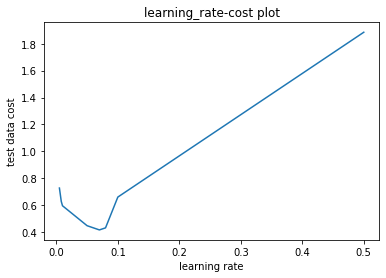

In [52]:
plt.plot(lrs, np.array(accs)[:, -1])
plt.title('learning_rate-cost plot')
plt.xlabel('learning rate')
plt.ylabel('test data cost');
print('minimum cost occured by lr =', lrs[np.argmin(np.array(accs)[:, -1])])

##### Step1 result: As we can see, best learning rate is occuring at lr = 0.07 

### Step2: Learning Rate Impact

The learning rate controls the pace of changing of the parameters.

   - When lr is very high:
        + the parameters change faster and we can reach an optimum point faster(in fewer epoches)
        - The drawback is that we may reach a sub-optimum, not a global optimum.
        - We may oscillate around a minima

   - When lr is very low:
        + We will obtain convergence(to local or global minima)
        - We may get stuck in a sub-optimum point
        - The drawback is that the parameters change slower and we can reach an optimum point slowly so we we will need more epoches to converge,

##### LR \\(\times \frac{1}{10}\\)

In [55]:
FitModel(lr=0.007, batch_size=32, activation=Relu(), weight_method='normal', init_method='he');


Epoch 1:
	Train: Average Accuracy: 51.28%	Average Loss: 1.5
	 Test: Average Accuracy: 57.25%	Average Loss: 1.27

Epoch 2:
	Train: Average Accuracy: 59.48%	Average Loss: 1.19
	 Test: Average Accuracy: 66.31%	Average Loss: 1.06

Epoch 3:
	Train: Average Accuracy: 73.6%	Average Loss: 0.83
	 Test: Average Accuracy: 75.32%	Average Loss: 0.77


##### LR \\(\times 10\\)

In [54]:
FitModel(lr=0.7, batch_size=32, activation=Relu(), weight_method='uniform', init_method='he');


Epoch 1:
	Train: Average Accuracy: 14.61%	Average Loss: 2.12
	 Test: Average Accuracy: 9.58%	Average Loss: 2.11

Epoch 2:
	Train: Average Accuracy: 15.87%	Average Loss: 2.04
	 Test: Average Accuracy: 28.64%	Average Loss: 1.93

Epoch 3:
	Train: Average Accuracy: 21.95%	Average Loss: 1.91
	 Test: Average Accuracy: 29.11%	Average Loss: 1.9


##### Step2 Result: As we expected:
   - when lr was *1/10 of the best, it has learning is slower and needs more epochs
   - when lr was *10 of the best, the learning does not converge and divreges around a local minima.  

### Step3: Impact of Activation Functions

##### Leaky Relu

In [115]:
FitModel(lr=0.07, batch_size=32, activation=LeakyRelu(), weight_method='uniform', init_method='he');


Epoch 1:
	Train: Average Accuracy: 73.47%	Average Loss: 0.73
	 Test: Average Accuracy: 82.33%	Average Loss: 0.5

Epoch 2:
	Train: Average Accuracy: 83.6%	Average Loss: 0.46
	 Test: Average Accuracy: 84.03%	Average Loss: 0.44

Epoch 3:


KeyboardInterrupt: 

##### Tanh

In [57]:
FitModel(lr=0.07, batch_size=32, activation=Tanh(), weight_method='uniform', init_method='he');


Epoch 1:
	Train: Average Accuracy: 70.78%	Average Loss: 0.8
	 Test: Average Accuracy: 80.81%	Average Loss: 0.54

Epoch 2:
	Train: Average Accuracy: 82.96%	Average Loss: 0.49
	 Test: Average Accuracy: 82.37%	Average Loss: 0.49

Epoch 3:
	Train: Average Accuracy: 84.3%	Average Loss: 0.44
	 Test: Average Accuracy: 82.81%	Average Loss: 0.46


##### Sigmoid

In [58]:
FitModel(lr=0.07, batch_size=32, activation=Sigmoid(), weight_method='uniform', init_method='he');


Epoch 1:
	Train: Average Accuracy: 69.74%	Average Loss: 0.84
	 Test: Average Accuracy: 81.32%	Average Loss: 0.54

Epoch 2:
	Train: Average Accuracy: 83.04%	Average Loss: 0.49
	 Test: Average Accuracy: 83.75%	Average Loss: 0.46

Epoch 3:
	Train: Average Accuracy: 84.47%	Average Loss: 0.44
	 Test: Average Accuracy: 84.14%	Average Loss: 0.45


### Step4: Impact of the Batch Size

##### batch size = Very Small

In [75]:
FitModel(lr=0.07, batch_size=4, activation=Relu(), weight_method='uniform', init_method='he');


Epoch 1:
	Train: Average Accuracy: 41.38%	Average Loss: 1.57
	 Test: Average Accuracy: 43.39%	Average Loss: 1.5

Epoch 2:
	Train: Average Accuracy: 43.16%	Average Loss: 1.49
	 Test: Average Accuracy: 40.89%	Average Loss: 1.57

Epoch 3:
	Train: Average Accuracy: 43.6%	Average Loss: 1.47
	 Test: Average Accuracy: 42.7%	Average Loss: 1.52
execution time = 23.34 seconds


##### batch size = 16

In [78]:
FitModel(lr=0.07, batch_size=16, activation=Relu(), weight_method='uniform', init_method='he');


Epoch 1:
	Train: Average Accuracy: 76.97%	Average Loss: 0.63
	 Test: Average Accuracy: 80.65%	Average Loss: 0.5

Epoch 2:
	Train: Average Accuracy: 84.1%	Average Loss: 0.44
	 Test: Average Accuracy: 84.16%	Average Loss: 0.44

Epoch 3:
	Train: Average Accuracy: 85.17%	Average Loss: 0.41
	 Test: Average Accuracy: 85.18%	Average Loss: 0.42

 execution time = 10.32 seconds


##### batch size = 128

In [79]:
FitModel(lr=0.07, batch_size=128, activation=Relu(), weight_method='uniform', init_method='he');


Epoch 1:
	Train: Average Accuracy: 56.6%	Average Loss: 1.15
	 Test: Average Accuracy: 75.49%	Average Loss: 0.7

Epoch 2:
	Train: Average Accuracy: 77.51%	Average Loss: 0.63
	 Test: Average Accuracy: 77.72%	Average Loss: 0.63

Epoch 3:
	Train: Average Accuracy: 81.52%	Average Loss: 0.53
	 Test: Average Accuracy: 80.93%	Average Loss: 0.54

 execution time = 13.50 seconds


##### batch size = Very Large

In [81]:
FitModel(lr=0.07, batch_size=3000, activation=Relu(), weight_method='uniform', init_method='he');


Epoch 1:
	Train: Average Accuracy: 9.79%	Average Loss: 2.29
	 Test: Average Accuracy: 10.14%	Average Loss: 2.28

Epoch 2:
	Train: Average Accuracy: 10.22%	Average Loss: 2.25
	 Test: Average Accuracy: 10.57%	Average Loss: 2.21

Epoch 3:
	Train: Average Accuracy: 15.05%	Average Loss: 2.13
	 Test: Average Accuracy: 32.05%	Average Loss: 2.01

 execution time = 9.50 seconds


#### Why do we use batch gradient descent?
   - In SGD we don't use the vectorization power to speed up the computations so it is slow.  
   - In Full Gradient Descent, if the data is too huge, it is not memory efficient to store very large matrices in memory.
    
We use (mini)batch gradient which is a combination of these two methods and each time uses a portion of data.

##### Step4 Result:
   - The execution time is faster when using large batches because if we use large batch we use vectorization power(Parallelism) to speed up the computations.
   - But when using large batches, updates are smaller so it needs more epoches.
   - small batch ---> slower execution but faster updates
   - large batch ---> faster execution but slower updates

### Step5: Impact of Epoch

##### Why is epoch necessery?
In each epoch the parameters are updated once. So to update the parameters to find the best parameters.

In [146]:
num_epoches = 50
_, log = FitModel(lr=0.07, batch_size=70, activation=Relu(), init_method='he',
                  weight_method='uniform', num_epoches=num_epoches);


Epoch 1:
	Train: Average Accuracy: 65.79%	Average Loss: 0.92
	 Test: Average Accuracy: 75.09%	Average Loss: 0.65

Epoch 2:
	Train: Average Accuracy: 81.49%	Average Loss: 0.53
	 Test: Average Accuracy: 74.76%	Average Loss: 0.7

Epoch 3:
	Train: Average Accuracy: 83.56%	Average Loss: 0.47
	 Test: Average Accuracy: 76.93%	Average Loss: 0.6

Epoch 4:
	Train: Average Accuracy: 84.55%	Average Loss: 0.44
	 Test: Average Accuracy: 80.69%	Average Loss: 0.56

Epoch 5:
	Train: Average Accuracy: 85.2%	Average Loss: 0.42
	 Test: Average Accuracy: 84.62%	Average Loss: 0.43

Epoch 6:
	Train: Average Accuracy: 85.7%	Average Loss: 0.4
	 Test: Average Accuracy: 77.83%	Average Loss: 0.61

Epoch 7:
	Train: Average Accuracy: 86.02%	Average Loss: 0.39
	 Test: Average Accuracy: 84.28%	Average Loss: 0.44

Epoch 8:
	Train: Average Accuracy: 86.37%	Average Loss: 0.38
	 Test: Average Accuracy: 85.03%	Average Loss: 0.42

Epoch 9:
	Train: Average Accuracy: 86.64%	Average Loss: 0.37
	 Test: Average Accuracy: 80.64

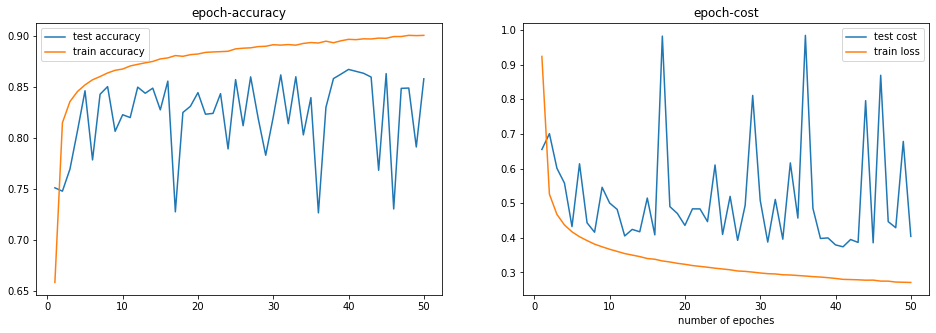

In [155]:
epoches = np.arange(1, num_epoches+1)
test_accs = log['test_accuracy']
test_costs = log['test_loss']

train_accs = log['train_accuracy']
train_costs = log['train_loss']   

fig, ax = plt.subplots(1,2, figsize=(16,5))
ax1, ax2 = ax

ax1.plot(epoches, test_accs, label='test accuracy')
ax1.plot(epoches, train_accs, label='train accuracy')
ax1.set_title('epoch-accuracy')
ax2.set_xlabel('number of epoches')
ax1.legend();

ax2.plot(epoches, test_costs, label='test cost')
ax2.plot(epoches, train_costs, label='train loss')
ax2.set_title('epoch-cost')
ax2.set_xlabel('number of epoches')
ax2.legend();

##### Step5 Result:
After some epoches, the model starts to learn the noises of the train data. Noises are the points that are not describing the behaviour of data. So the model starts to lose the generalization and hence will not perform well on the data other than train data. As we can see in above plots loss on the train data is constantly decreasing and accuracy is increasing but on the test data after some time of decreasing of loss, loss starts increasing and accuracy starts decreasing. Hence the model is overfitting after some epoches.

In [169]:
network, _ = FitModel(lr=0.07, batch_size=32, activation=Relu(), n_neurons=[2,10])


Epoch 1:
	Train: Average Accuracy: 9.54%	Average Loss: 2.17
	 Test: Average Accuracy: 9.71%	Average Loss: 2.11

Epoch 2:
	Train: Average Accuracy: 9.59%	Average Loss: 2.11
	 Test: Average Accuracy: 9.55%	Average Loss: 2.11

Epoch 3:
	Train: Average Accuracy: 9.53%	Average Loss: 2.11
	 Test: Average Accuracy: 9.25%	Average Loss: 2.12

 execution time = 6.06 seconds


In [170]:
lines, X_train_2D = network.transform(X_train)
lines, X_test_2D = network.transform(X_test)

In [171]:
X_train_2D_df = pd.DataFrame(X_train_2D)
X_test_2D_df = pd.DataFrame(X_test_2D)

In [172]:
X_train_2D_df['class'] = pd.DataFrame(y_train)
X_test_2D_df['class'] = pd.DataFrame(y_test)
X_test_2D_df.loc[0] = X_test_2D_df.loc[0]

In [173]:
# X_test_2D_df.loc[:,1] *= 30000

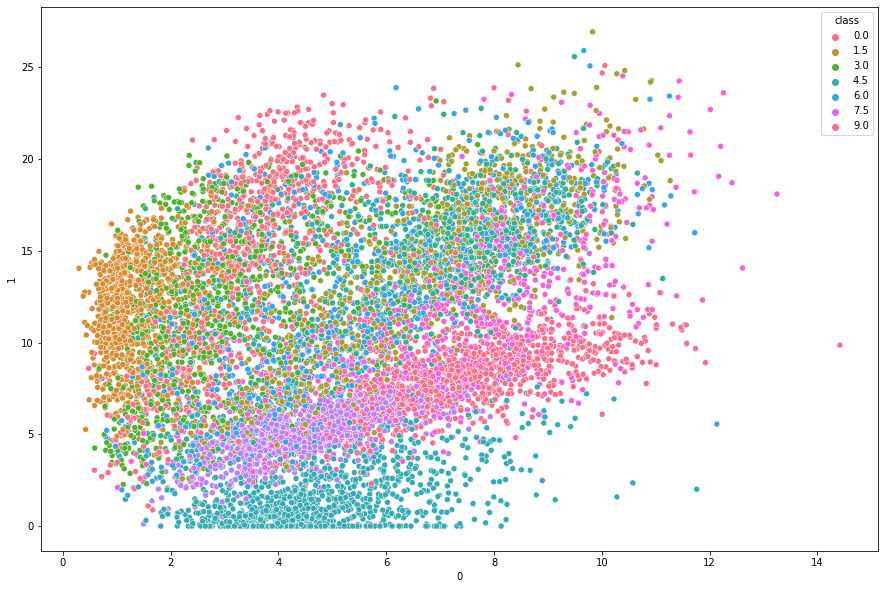

In [175]:
plt.figure(figsize=(15,10))
sns.scatterplot(data=X_test_2D_df[:], x=0, y=1, hue="class", palette='husl');